## CIFAR-10 图像分类：初步实现

### 1. 导入所需库

首先，导入所需的 Python 库：

In [37]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns # 用于更美观的混淆矩阵可视化

# 用于在 Notebook 中显示 matplotlib 图像
%matplotlib inline

### 2. 设备配置与超参数设定

检查 CUDA 是否可用，以决定使用 GPU 还是 CPU 进行训练。同时，定义一些关键的超参数，如学习率、批次大小和训练周期数。

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"当前使用的设备是: {device}")

# 定义超参数
LEARNING_RATE = 0.001
BATCH_SIZE = 64 
EPOCHS = 100

# CIFAR-10 类别
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

当前使用的设备是: cuda:0


### 3. 数据加载、预处理与增强

该步骤涉及 CIFAR-10 数据集的加载与准备。关键操作包括：
1.  **数据变换 (Transforms):** 
    *   `ToTensor()`: 将 PIL 图像或 NumPy `ndarray` 转换为 `FloatTensor`，并将图像的像素值范围从 [0, 255] 归一化到 [0.0, 1.0]。
    *   `Normalize(mean, std)`: 用给定的均值 (mean) 和标准差 (std) 对张量图像进行归一化，这有助于加速模型收敛并提高稳定性。CIFAR-10 数据集常用的均值和标准差为 `(0.4914, 0.4822, 0.4465)` 和 `(0.2023, 0.1994, 0.2010)`，参考[https://stackoverflow.com/a/68123869/29793656](https://stackoverflow.com/a/68123869/29793656)
    *   **数据增强 (Data Augmentation):** 仅对训练集应用，增加数据多样性，提高模型泛化能力。例如 `RandomHorizontalFlip()` (随机水平翻转) 和 `RandomCrop()` (随机裁剪)等。
2.  **数据集下载与加载:** 使用 `torchvision.datasets.CIFAR10` 下载并加载数据集。
3.  **数据加载器 (DataLoader):** 使用 `torch.utils.data.DataLoader` 创建数据加载器，并支持数据打乱 (`shuffle=True` for training)。

In [39]:
# 定义训练集的数据增强和预处理
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # 随机水平翻转
    transforms.RandomHorizontalFlip(), # 随机裁剪
    transforms.RandomRotation(15), # 随机旋转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # 颜色抖动
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 测试集的 transform_test 保持不变
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 加载 CIFAR-10 训练集和测试集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=16) # num_workers用于多进程加载数据

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=16)

print(f"训练集样本数: {len(trainset)}")
print(f"测试集样本数: {len(testset)}")

Files already downloaded and verified
Files already downloaded and verified
训练集样本数: 50000
测试集样本数: 10000


### 4. 模型定义 (卷积神经网络与深度可分离卷积)

**注意：在该笔记中，我尝试了两种网络结构。**

#### 4.1 自己定义的简单网络

根据要求，模型需包含**深度可分离卷积 (Depthwise Separable Convolution)**。深度可分离卷积将标准卷积分解为两个步骤：
1.  **深度卷积 (Depthwise Convolution):** 对每个输入通道独立应用一个卷积核。通过 `nn.Conv2d` 的 `groups` 参数实现，当 `groups` 等于输入通道数 `in_channels` 时，即为深度卷积。
2.  **逐点卷积 (Pointwise Convolution):** 一个标准的 1x1 卷积，用于组合深度卷积产生的特征图，并调整通道数。

我们首先定义一个深度可分离卷积模块，然后将其集成到主网络结构中。在我的网络结构中，包含若干卷积层、深度可分离卷积层、激活函数 (如 ReLU)、池化层 (如 MaxPool2d) 和全连接层。

In [40]:
class DepthwiseSeparableConv(nn.Module):
    """深度可分离卷积模块"""
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseSeparableConv, self).__init__()
        # 深度卷积: groups=in_channels 使得每个输入通道独立进行卷积
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                   stride=stride, padding=padding, groups=in_channels, bias=False)
        self.bn_depthwise = nn.BatchNorm2d(in_channels) # 在深度卷积后接BN
        # 逐点卷积: 1x1 卷积
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn_pointwise = nn.BatchNorm2d(out_channels) # 在逐点卷积后接BN

    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn_depthwise(x)
        x = F.relu(x) # 激活函数
        x = self.pointwise(x)
        x = self.bn_pointwise(x)
        x = F.relu(x) # 激活函数
        return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 初始卷积层
        self.conv1 = nn.Conv2d(3, 48, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(48)
        
        # 第一个深度可分离卷积层
        self.dsc1 = DepthwiseSeparableConv(48, 96, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2 Max Pooling
        self.dropout1 = nn.Dropout(0.25) # Dropout层防止过拟合

        # 第二个深度可分离卷积层
        self.dsc2 = DepthwiseSeparableConv(96, 192, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        # 第三个深度可分离卷积层
        self.dsc3 = DepthwiseSeparableConv(192, 384, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)
        
        # 全连接层
        # 输入尺寸计算: 初始32x32 -> pool1后16x16 -> pool2后8x8 -> pool3后4x4
        # 因此，flatten后的特征数量为 384 * 4 * 4
        self.fc1 = nn.Linear(384 * 4 * 4, 512) 
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10) # CIFAR-10 有10个类别

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        
        x = self.dsc1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.dsc2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.dsc3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = x.view(-1, 384 * 4 * 4) # Flatten操作
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x) # 输出层不需要激活函数，因为CrossEntropyLoss会处理
        return x

model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dsc1): DepthwiseSeparableConv(
    (depthwise): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
    (bn_depthwise): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pointwise): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn_pointwise): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dsc2): DepthwiseSeparableConv(
    (depthwise): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96, bias=False)
    (bn_depthwise): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pointwise): Conv2d(96, 192, ker

#### 以下是该模型的网络架构图：

In [77]:
import uuid

class Mermaid:
    def __init__(self, diagram: str):
        self._diagram = self._process_diagram(diagram)
        self._uid = uuid.uuid4()

    @staticmethod
    def _process_diagram(diagram: str) -> str:
        _diagram = diagram.replace("\n", "\\n")
        _diagram = _diagram.lstrip("\\n")
        _diagram = _diagram.replace("'", '"')
        return _diagram

    def _repr_html_(self) -> str:
        ret = f"""
        <div class="mermaid-{self._uid}" style="background-color: white;"></div>
        <script type="module">
            import mermaid from 'https://cdn.jsdelivr.net/npm/mermaid@10.1.0/+esm'
            const graphDefinition = '{self._diagram}';
            const element = document.querySelector('.mermaid-{self._uid}');
            const {{ svg }} = await mermaid.render('graphDiv-{self._uid}', graphDefinition);
            element.innerHTML = svg;
        </script>
        """
        return ret

Mermaid("""
graph TD;
    A[Input<br/>&#40 3&#64 32x32&#41 ];
    B["<b>Initial Block</b><br/>conv1: Conv2d<br/>&#40 3,48,k=3,p=1&#41 <br/>bn1: BatchNorm2d&#40 48&#41 <br/>ReLU<br/><i>Output: 48@32x32</i>"];
    A --> B;

    subgraph dsc1 [dsc1: DepthwiseSeparableConv&#40 48, 96&#41 ];
        direction LR;
        DSC1_DW["DepthwiseConv<br/>&#40 48,48,k=3,p=1,g=48&#41 <br/><i>48@32x32</i>"];
        DSC1_BN_RELU_DW["BatchNorm2d&#40 48&#41 <br/>ReLU"];
        DSC1_PW["PointwiseConv&#40 48,96,k=1&#41 "];
        DSC1_BN_RELU_PW["BatchNorm2d&#40 96&#41 <br/>ReLU<br/><i>Output: 96@32x32</i>"];
        DSC1_DW --> DSC1_BN_RELU_DW --> DSC1_PW --> DSC1_BN_RELU_PW;
    end
    B --> DSC1_DW;

    C["pool1: MaxPool2d&#40 k=2,s=2&#41 <br/><i>Output: 96@16x16</i>"];
    D1[dropout1: Dropout&#40 0.25&#41 ];
    DSC1_BN_RELU_PW --> C;
    C --> D1;

    subgraph pd1;
        C;
        D1;
    end

    subgraph dsc2 [dsc2: DepthwiseSeparableConv&#40 96, 192&#41 ];
        direction LR;
        DSC2_DW["DepthwiseConv<br/>&#40 96,96,k=3,p=1,g=96&#41 <br/><i>96@16x16</i>"];
        DSC2_BN_RELU_DW["BatchNorm2d&#40 96&#41 <br/>ReLU"];
        DSC2_PW["PointwiseConv&#40 96,192,k=1&#41 "];
        DSC2_BN_RELU_PW["BatchNorm2d&#40 192&#41 <br/>ReLU<br/><i>Output: 192@16x16</i>"];
        DSC2_DW --> DSC2_BN_RELU_DW --> DSC2_PW --> DSC2_BN_RELU_PW;
    end
    D1 --> DSC2_DW;

    E["pool2: MaxPool2d&#40 k=2,s=2&#41 <br/><i>Output: 192@8x8</i>"];
    F1[dropout2: Dropout&#40 0.25&#41 ];
    DSC2_BN_RELU_PW --> E;
    E --> F1;

    subgraph pd2;
        E;
        F1;
    end

    subgraph dsc3 [dsc3: DepthwiseSeparableConv&#40 192, 384&#41 ];
        direction LR;
        DSC3_DW["DepthwiseConv<br/>&#40 192,192,k=3,p=1,g=192&#41 <br/><i>192@8x8</i>"];
        DSC3_BN_RELU_DW["BatchNorm2d&#40 192&#41 <br/>ReLU"];
        DSC3_PW["PointwiseConv&#40 192,384,k=1&#41 "];
        DSC3_BN_RELU_PW["BatchNorm2d&#40 384&#41 <br/>ReLU<br/><i>Output: 384@8x8</i>"];
        DSC3_DW --> DSC3_BN_RELU_DW --> DSC3_PW --> DSC3_BN_RELU_PW;
    end
    F1 --> DSC3_DW;
    
    G["pool3: MaxPool2d&#40 k=2,s=2&#41 <br/><i>Output: 384@4x4</i>"];
    H1[dropout3: Dropout&#40 0.25&#41 ];
    DSC3_BN_RELU_PW --> G;
    G --> H1;

    subgraph pd3;
        G;
        H1;
    end

    subgraph dsc [Depthwise Separable Convolution];
        dsc1;
        dsc2;
        dsc3;
    end

    subgraph pool &#38 dropout
        pd1;
        pd2;
        pd3;
    end

    I["Flatten &#40 View&#41 <br/><i>Input: 384 * 4 * 4 = 6144 features</i>"];
    J["<b>Fully Connected Block</b><br/>fc1: Linear&#40 6144,512&#41 <br/>ReLU"];
    K[dropout_fc: Dropout&#40 0.5&#41 ];
    L[fc2: Linear&#40 512,10&#41 ];
    M[Output<br/>&#40 10 classes&#41 ];

    H1 --> I;
    I --> J;
    J --> K;
    K --> L;
    L --> M;
""")

#### 4.2 另一种方案

以上模型在测试集上的准确率已经可以达到 80% 了，但为了追求更高的准确率并采用更复杂的模型结构，我们可以选用 `ResNet-18` 架构，并在其基础上进行改进。

我们先使用自己定义的网络进行训练，随后尝试 ResNet-18 网络架构，**其结果将附在最后**。

### 5. 定义损失函数与优化器

对于多分类任务，常用的损失函数是**交叉熵损失 (Cross-Entropy Loss)**，在 PyTorch 中通过 `nn.CrossEntropyLoss()` 实现。该损失函数内部集成了 `LogSoftmax` 和 `NLLLoss`，因此模型输出层通常不需要显式添加 Softmax激活函数。

我们还需要选择**优化器 (Optimizer)** 来更新模型的权重。Adam 优化器 (`optim.Adam`) 是一种常用的自适应学习率优化算法，通常具有较好的性能，因此我先用它进行训练。

为进一步优化学习过程，我们可以采用余弦退火学习率调度器 (`torch.optim.lr_scheduler.CosineAnnealingLR`)。该调度器依据余弦函数曲线，在指定的周期 (`T_max`) 内将学习率从初始值**平滑地**降低至一个设定的**最小值** (`eta_min`)。这种策略有助于模型在训练后期更稳定地收敛，从而达到更优的性能。

In [42]:
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adam优化器
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=0.00001) # 余弦退火学习率调度器

### 6. 训练模型

训练过程在一个循环中进行，每个循环代表表示一个**训练周期 (Epoch)**。在每个周期内，模型遍历整个训练数据集。
对于每个批次 (Batch) 的数
1.  将数据和标签移动到指定设备 (GPU/CPU)。
2.  **梯度清零:** `optimizer.zero_grad()`，清除上一轮迭代的梯度信息。
3.  **前向传播:** `outputs = model(inputs)`，将输入数据送入模型，得到预测输出。
4.  **计算损失:** `loss = criterion(outputs, labels)`，根据预测输出和真实标签计算损失。
5.  **反向传播:** `loss.backward()`，计算损失相对于模型参数的梯度。
6.  **参数更新:** `optimizer.step()`，根据梯度更新模型参数。

在训练过程中，我们可以记录并打印每个周期的平均训练损失和准确率，以监控训练状态。

In [43]:
def train_model(model, trainloader, criterion, optimizer, epochs, scheduler=None):
    model.train() # 设置模型为训练模式
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0) # 乘以batch_size以得到总损失
            
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            if (i + 1) % 100 == 0: # 每100个mini-batches打印一次信息
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}')
        
        epoch_loss = running_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        print(f'Epoch {epoch+1}结束: 平均训练损失: {epoch_loss:.4f}, 训练准确率: {epoch_accuracy:.4f}')
        
        if scheduler:
            scheduler.step()
            current_lr = optimizer.param_groups[0]['lr']
            print(f'调用学习率调度器， 当前学习率: {current_lr:.6f}')
    
    print('训练完成')
    return train_losses, train_accuracies

# 开始训练
train_losses, train_accuracies = train_model(model, trainloader, criterion, optimizer, epochs=EPOCHS, scheduler=scheduler)

Epoch [1/100], Step [100/782], Loss: 2.0068
Epoch [1/100], Step [200/782], Loss: 2.0886
Epoch [1/100], Step [300/782], Loss: 2.0228
Epoch [1/100], Step [400/782], Loss: 2.2705
Epoch [1/100], Step [500/782], Loss: 1.7267
Epoch [1/100], Step [600/782], Loss: 1.7351
Epoch [1/100], Step [700/782], Loss: 1.7890
Epoch 1结束: 平均训练损失: 1.9862, 训练准确率: 0.2493
调用学习率调度器， 当前学习率: 0.001000
Epoch [2/100], Step [100/782], Loss: 2.0746
Epoch [2/100], Step [200/782], Loss: 2.0116
Epoch [2/100], Step [300/782], Loss: 1.8088
Epoch [2/100], Step [400/782], Loss: 1.7179
Epoch [2/100], Step [500/782], Loss: 2.0911
Epoch [2/100], Step [600/782], Loss: 1.7737
Epoch [2/100], Step [700/782], Loss: 1.8071
Epoch 2结束: 平均训练损失: 1.7577, 训练准确率: 0.3156
调用学习率调度器， 当前学习率: 0.000999
Epoch [3/100], Step [100/782], Loss: 2.0025
Epoch [3/100], Step [200/782], Loss: 1.5238
Epoch [3/100], Step [300/782], Loss: 1.6941
Epoch [3/100], Step [400/782], Loss: 1.7145
Epoch [3/100], Step [500/782], Loss: 1.5498
Epoch [3/100], Step [600/782],

### 7. 评估模型

在模型训练完成后，使用测试数据集评估其性能。评估过程与训练类似，但不进行梯度计算和参数更新。
1.  将模型设置为评估模式: `model.eval()`，关闭 Dropout 和 BatchNorm 的更新等训练行为。
2.  使用 `torch.no_grad()` 上下文管理器，禁用梯度计算，以减少内存消耗并加速计算。
3.  遍历测试数据加载器，计算总损失和准确率。
4.  收集所有真实标签和预测标签，用于后续的混淆矩阵和样本可视化。

In [44]:
def evaluate_model(model, testloader, criterion):
    model.eval() # 设置模型为评估模式
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad(): # 在评估阶段不计算梯度
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy()) # 收集真实标签
            all_predictions.extend(predicted.cpu().numpy()) # 收集预测标签

    avg_test_loss = test_loss / total_samples
    accuracy = correct_predictions / total_samples
    
    print(f'测试集: 平均损失: {avg_test_loss:.4f}, 准确率: {correct_predictions}/{total_samples} ({accuracy:.2%})')
    return avg_test_loss, accuracy, all_labels, all_predictions

# 评估模型
test_loss, test_accuracy, true_labels, pred_labels = evaluate_model(model, testloader, criterion)

测试集: 平均损失: 0.4813, 准确率: 8433/10000 (84.33%)


### 8. 结果可视化

#### 8.1 训练过程可视化 (损失与准确率曲线)
绘制训练过程中的损失和准确率曲线，可以观察模型的收敛情况。

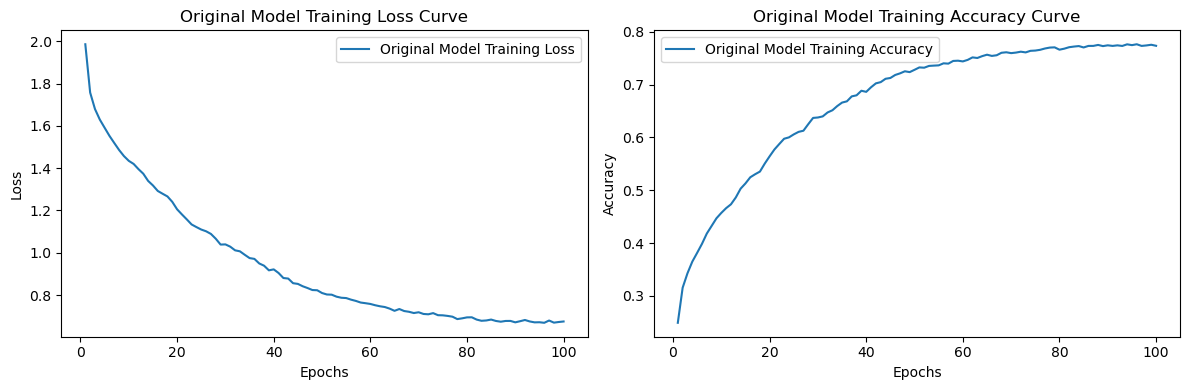

In [45]:
def plot_training_curves(epochs_list, train_losses, train_accuracies, model_name=""):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_list, train_losses, label=f'{model_name} Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_list, train_accuracies, label=f'{model_name} Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Training Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(range(1, EPOCHS + 1), train_losses, train_accuracies, model_name="Original Model")

#### 8.2 混淆矩阵 (Confusion Matrix)

混淆矩阵清晰地展示了模型在各个类别上的分类情况，特别是哪些类别容易被混淆。使用 `sklearn.metrics.confusion_matrix` 计算，并用 `seaborn.heatmap` 或 `matplotlib.pyplot.imshow` 进行可视化。此处选用前者，因为个人认为更加美观一些。

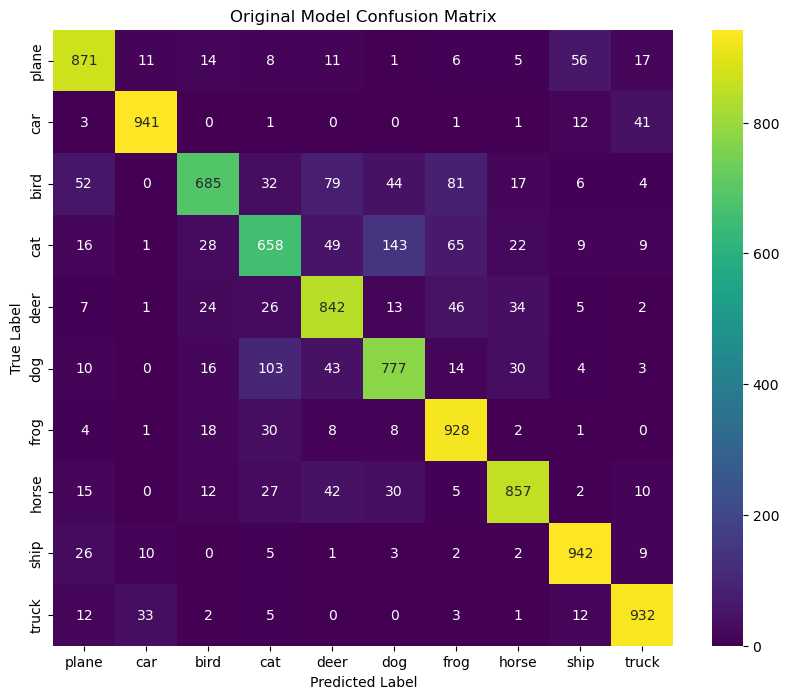

In [46]:
def plot_confusion_matrix_heatmap(true_labels, pred_labels, class_names, model_name=""):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

plot_confusion_matrix_heatmap(true_labels, pred_labels, classes, model_name="Original Model")

可以看出来，模型在识别 `bird`, `cat`, `dog` 这三种动物时准确率没能达到80%以上，其中 `cat` 与 `dog` 的混淆情况尤为严重。

#### 8.3 样本图片、真实标签与预测标签展示

随机抽取一部分测试集图片，展示其真实图像、真实标签以及模型的预测标签，有助于直观感受模型的分类效果。
**注意**：由于数据加载时进行了归一化，显示图像前需要进行**反归一化**操作，以还原图像的原始像素值范围。

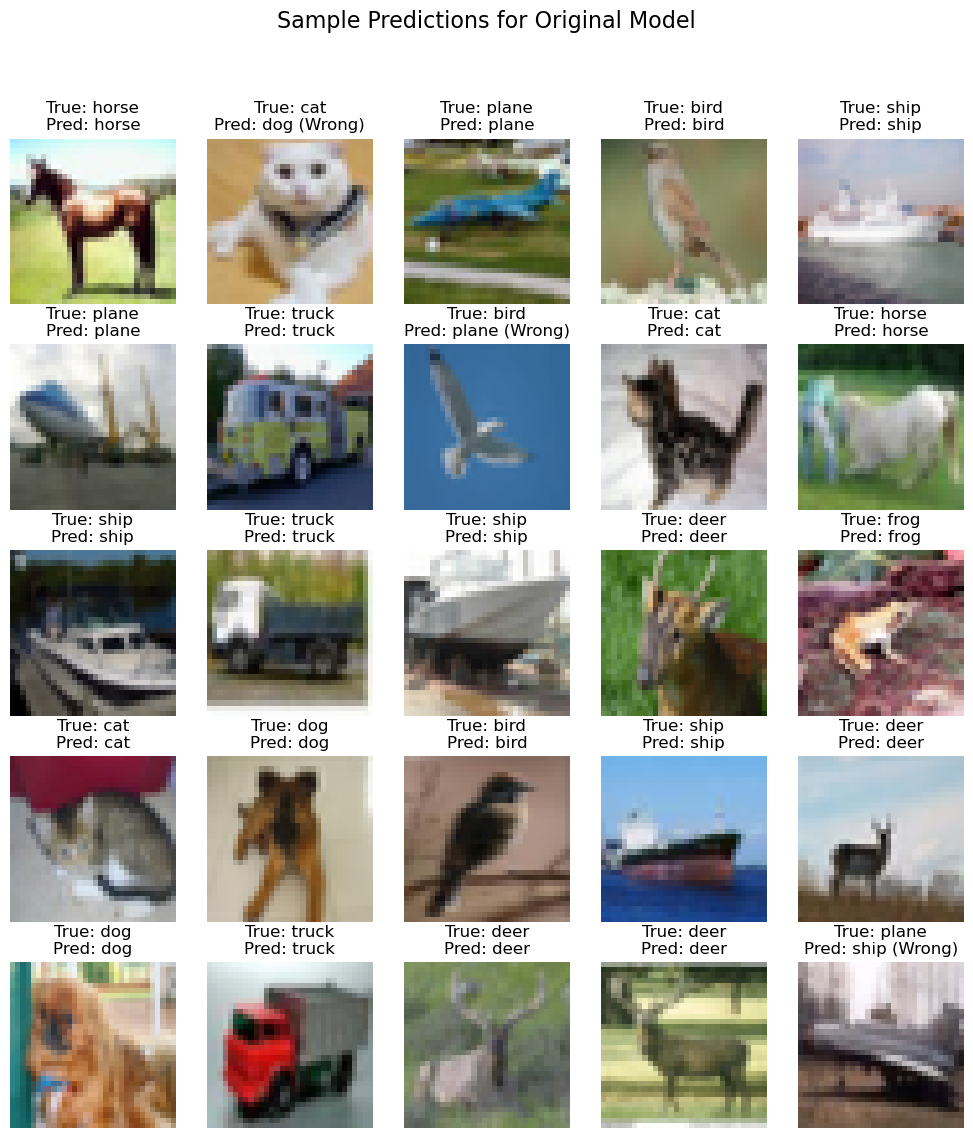

In [47]:
# 显示反归一化后的图像及其标题
def imshow_with_predictions(img_tensor, title):
    # 反归一化: PyTorch中的图像是 C x H x W, Matplotlib 需要 H x W x C
    # 均值和标准差 (与预处理时一致)
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    
    img_np = img_tensor.numpy().transpose((1, 2, 0)) # C,H,W -> H,W,C
    img_np = std * img_np + mean # 反归一化
    img_np = np.clip(img_np, 0, 1) # 将像素值限制在 [0, 1] 范围内
    
    plt.imshow(img_np)
    plt.title(title)
    plt.axis('off')

# 可视化一部分测试图片的真实标签和预测标签
def visualize_sample_predictions(dataset, model_to_eval, current_device, class_names, num_images=25, model_name=""):
    model_to_eval.eval()
    
    cols = int(np.ceil(np.sqrt(num_images)))
    rows = int(np.ceil(num_images / cols))
    
    plt.figure(figsize=(cols * 2, rows * 2.2))
    if model_name:
        plt.suptitle(f"Sample Predictions for {model_name}", fontsize=16, y=1.03)

    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    for i, idx in enumerate(indices):
        img_tensor, label = dataset[idx] 
        img_for_model = img_tensor.unsqueeze(0).to(current_device) 
        
        with torch.no_grad():
            output = model_to_eval(img_for_model)
            _, predicted_idx = torch.max(output, 1)
        
        predicted_class = class_names[predicted_idx.item()]
        true_class = class_names[label]
        
        plt.subplot(rows, cols, i + 1)
        title_str = f"True: {true_class}\nPred: {predicted_class}"
        if predicted_class != true_class:
            title_str = f"{title_str} (Wrong)"
        
        imshow_with_predictions(img_tensor.cpu(), title_str) # imshow_with_predictions 内部处理反归一化
        
    plt.tight_layout(rect=[0, 0, 1, 0.99]) # 调整布局以适应主标题
    plt.show()

# 可视化测试集中的预测结果 (注意: testset 包含的是已经 transform 过的图像)
visualize_sample_predictions(testset, model, device, classes, num_images=25, model_name="Original Model")

### 9. 保存模型

训练完成后，可以将模型的**状态字典 (state_dict)** 保存起来。状态字典包含了模型的所有可学习参数 (权重和偏置)。后续可以通过加载此状态字典来恢复模型，进行进一步的训练、评估或部署。
我们可以使用 `torch.save(model.state_dict(), PATH)` 保存，使用 `model.load_state_dict(torch.load(PATH))` 和 `model.to(device)` 加载。

In [48]:
MODEL_PATH = 'cifar10_cnn_depthwise_sep.pth'
torch.save(model.state_dict(), MODEL_PATH)
print(f"模型已保存到: {MODEL_PATH}")

# 如何加载模型:
# model_loaded = Net().to(device)
# model_loaded.load_state_dict(torch.load(MODEL_PATH))
# model_loaded.eval() # 设置为评估模式

模型已保存到: cifar10_cnn_depthwise_sep.pth


## 进阶模型探索：ResNetDSC-18

在原有模型达到作业要求的基础上，为了进一步提升模型性能并展现对更复杂网络结构的探索，本部分将对 **ResNet-18** 架构进行改进。

ResNet (Residual Network) 通过引入“快捷连接” (Shortcut Connections) 或“残差学习” (Residual Learning) 的思想，使得非常深的网络也能够有效地进行训练。我们将从 `torchvision.models` 中加载 ResNet-18 的骨干网络结构，并对其进行适应性修改以用于 CIFAR-10 数据集。

### R1. ResNetDSC-18 模型定义与配置

针对 CIFAR-10 (32x32图像)，对标准的 ResNet-18 进行如下调整：
1.  **修改初始卷积层 `conv1`**: 使用较小的卷积核 (3x3)、步长 (1) 和填充 (1)。
2.  **移除初始最大池化层 `maxpool`**: 通过将其替换为一个恒等映射 (`nn.Identity()`) 来实现，避免特征图尺寸过早过度减小。
3.  **全连接层 `fc`**: 确保其输出维度为 CIFAR-10 的10个类别 (此步骤在加载模型时已通过 `num_classes` 参数保证，因此不需要显式处理)。

根据作业要求，我们将 ResNet-18 的初始卷积层和第一个残差块中的卷积层替换为深度可分离卷积模块，设计出 **ResNetDSC-18** 模型，能够在保证模型性能的前提下，减少参数量。

In [78]:
class BasicBlockDSC(nn.Module):
    expansion = 1 # ResNet BasicBlock 的扩展因子为1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlockDSC, self).__init__()
        # 第一个卷积层 (原 conv1 + bn1 + relu) 被替换为 dsc1
        self.dsc1 = DepthwiseSeparableConv(inplanes, planes, kernel_size=3, stride=stride, padding=1)
        
        # 第二个卷积层 (原 conv2 + bn2) 被替换为 dsc2
        # 注意：第二个卷积的 stride 通常为 1
        self.dsc2 = DepthwiseSeparableConv(planes, planes, kernel_size=3, stride=1, padding=1)
        
        self.downsample = downsample # 下采样路径
        self.stride = stride
        self.relu_out = nn.ReLU(inplace=False) # 保留残差连接后的 ReLU

    def forward(self, x):
        identity = x

        out = self.dsc1(x)
        out = self.dsc2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        
        out = out + identity # 残差连接
        out = self.relu_out(out) # 应用最终的激活函数
        return out

class ResNetDSC(nn.Module):
    def __init__(self, block, layers, num_classes=10, zero_init_residual=False):
        super(ResNetDSC, self).__init__()
        self.inplanes = 64 # ResNet-18 初始的特征通道数

        # 初始卷积层 (原 conv1 + bn1 + relu for CIFAR-10)
        # 使用 DepthwiseSeparableConv 替换
        self.conv1_dsc = DepthwiseSeparableConv(3, self.inplanes, kernel_size=3, stride=1, padding=1)
        
        # 对于 CIFAR-10，通常不使用 ResNet 原始的初始 MaxPooling，因此使用恒等映射
        self.maxpool = nn.Identity() 

        # 构建 ResNet 的主要层
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # 自适应平均池化
        self.fc = nn.Linear(512 * block.expansion, num_classes) # 全连接分类层

        # 初始化权重
        for m in self.modules():
            if isinstance(m, nn.Conv2d): # 初始化 DepthwiseSeparableConv 内部的 Conv2d
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # 残差分支的最后一个 BN 层权重初始化为0，有助于训练非常深的网络
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicBlockDSC):
                    # dsc2 是 BasicBlockDSC 中的第二个深度可分离卷积
                    # bn_pointwise 是 DepthwiseSeparableConv 中逐点卷积后的 BN
                    nn.init.constant_(m.dsc2.bn_pointwise.weight, 0)

    def _make_layer(self, block, planes, num_blocks, stride=1):
        downsample = None
        # 何时需要下采样？
        # 1. stride 不为 1 (特征图尺寸变化)
        # 2. 输入通道数 self.inplanes 不等于目标输出通道数 planes * block.expansion
        if stride != 1 or self.inplanes != planes * block.expansion:
            # 原下采样路径是: nn.Conv2d(1x1) + nn.BatchNorm2d
            # 这里我们将1x1的 nn.Conv2d 替换为 DepthwiseSeparableConv
            # DepthwiseSeparableConv 内部已包含 BN，所以不需要额外的 BN 层
            downsample = DepthwiseSeparableConv(
                self.inplanes,
                planes * block.expansion,
                kernel_size=1, # 1x1 的卷积
                stride=stride, # 使用传入的 stride
                padding=0
            )

        layers = []
        # 第一个 block 可能需要处理 stride 和 downsample
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion # 更新下一层或下一个 block 的输入通道数
        # 后续的 blocks
        for _ in range(1, num_blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1_dsc(x) # 已经包含了 BN 和 ReLU
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# 辅助函数来实例化 ResNetDSC-18
def resnet18_dsc_cifar10(num_classes=10, zero_init_residual=False):
    return ResNetDSC(BasicBlockDSC, [2, 2, 2, 2], num_classes=num_classes, zero_init_residual=zero_init_residual)

# 实例化模型
model_resnet_dsc = resnet18_dsc_cifar10(num_classes=10).to(device)
print(model_resnet_dsc)

# 检查参数量
total_params_resnet_dsc = sum(p.numel() for p in model_resnet_dsc.parameters() if p.requires_grad)
print(f"ResNetDSC-18 模型总参数量: {total_params_resnet_dsc:,}")

# 为 ResNetDSC-18 定义新的超参数、优化器和学习率调度器
LEARNING_RATE_RESNET = 0.001
EPOCHS_RESNET = 100
BATCH_SIZE_RESNET = 256

optimizer_resnet = optim.Adam(model_resnet_dsc.parameters(), lr=LEARNING_RATE_RESNET, weight_decay=1e-4) # 添加权重衰减
scheduler_resnet = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_resnet, T_max=EPOCHS_RESNET, eta_min=1e-6)

ResNetDSC(
  (conv1_dsc): DepthwiseSeparableConv(
    (depthwise): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3, bias=False)
    (bn_depthwise): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pointwise): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn_pointwise): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlockDSC(
      (dsc1): DepthwiseSeparableConv(
        (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn_depthwise): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn_pointwise): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (dsc2): DepthwiseSeparableConv(
        (

### R2. 训练 ResNetDSC-18 模型

使用与之前定义的 `train_model` 函数相同的训练流程，但传入 ResNetDSC-18 模型及其对应的优化器和学习率调度器。

In [50]:
print("开始训练 ResNetDSC-18 模型...")
train_losses_resnet, train_accuracies_resnet = train_model(
    model_resnet_dsc, 
    trainloader,
    criterion,
    optimizer_resnet, 
    epochs=EPOCHS_RESNET, 
    scheduler=scheduler_resnet
)

开始训练 ResNet-18 模型...
Epoch [1/100], Step [100/782], Loss: 1.9642
Epoch [1/100], Step [200/782], Loss: 1.7490
Epoch [1/100], Step [300/782], Loss: 1.7440
Epoch [1/100], Step [400/782], Loss: 1.7288
Epoch [1/100], Step [500/782], Loss: 1.5696
Epoch [1/100], Step [600/782], Loss: 1.6539
Epoch [1/100], Step [700/782], Loss: 1.8216
Epoch 1结束: 平均训练损失: 1.7722, 训练准确率: 0.3448
调用学习率调度器， 当前学习率: 0.001000
Epoch [2/100], Step [100/782], Loss: 1.4469
Epoch [2/100], Step [200/782], Loss: 1.5500
Epoch [2/100], Step [300/782], Loss: 1.6901
Epoch [2/100], Step [400/782], Loss: 1.4658
Epoch [2/100], Step [500/782], Loss: 1.4561
Epoch [2/100], Step [600/782], Loss: 1.3124
Epoch [2/100], Step [700/782], Loss: 1.3911
Epoch 2结束: 平均训练损失: 1.4482, 训练准确率: 0.4762
调用学习率调度器， 当前学习率: 0.000999
Epoch [3/100], Step [100/782], Loss: 1.3616
Epoch [3/100], Step [200/782], Loss: 1.1551
Epoch [3/100], Step [300/782], Loss: 1.3962
Epoch [3/100], Step [400/782], Loss: 1.2469
Epoch [3/100], Step [500/782], Loss: 1.1634
Epoch [3/

### R3. 评估 ResNetDSC-18 模型

使用 `evaluate_model` 函数评估训练好的 ResNetDSC-18 模型在测试集上的性能。

In [51]:
print("评估 ResNetDSC-18 模型...")
test_loss_resnet, test_accuracy_resnet, true_labels_resnet, pred_labels_resnet = evaluate_model(
    model_resnet_dsc, 
    testloader,
    criterion
)

评估 ResNetDSC-18 模型...
测试集: 平均损失: 0.3021, 准确率: 9212/10000 (92.12%)


### R4. ResNetDSC-18 结果可视化

使用可视化函数展示 ResNetDSC-18 的训练曲线、混淆矩阵和样本预测。

绘制 ResNetDSC-18 训练曲线...


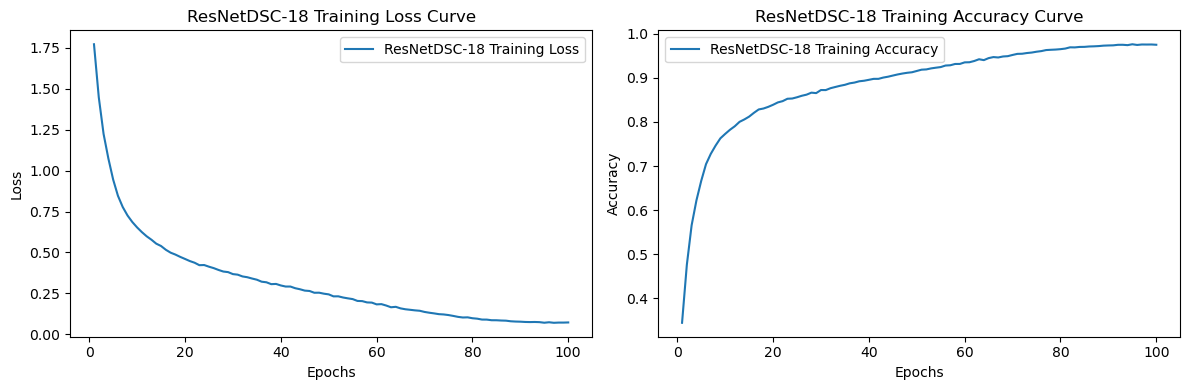

绘制 ResNetDSC-18 混淆矩阵...


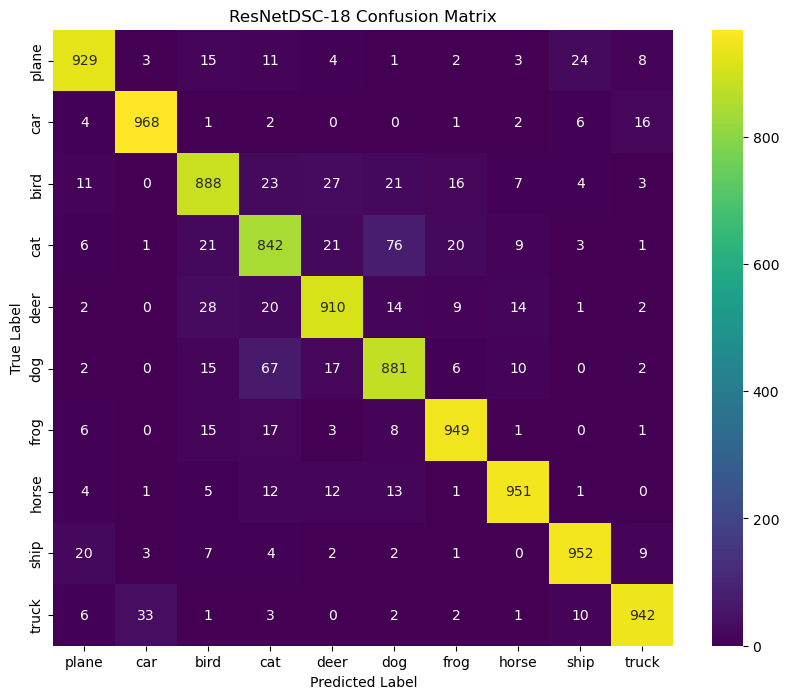

可视化 ResNetDSC-18 样本预测...


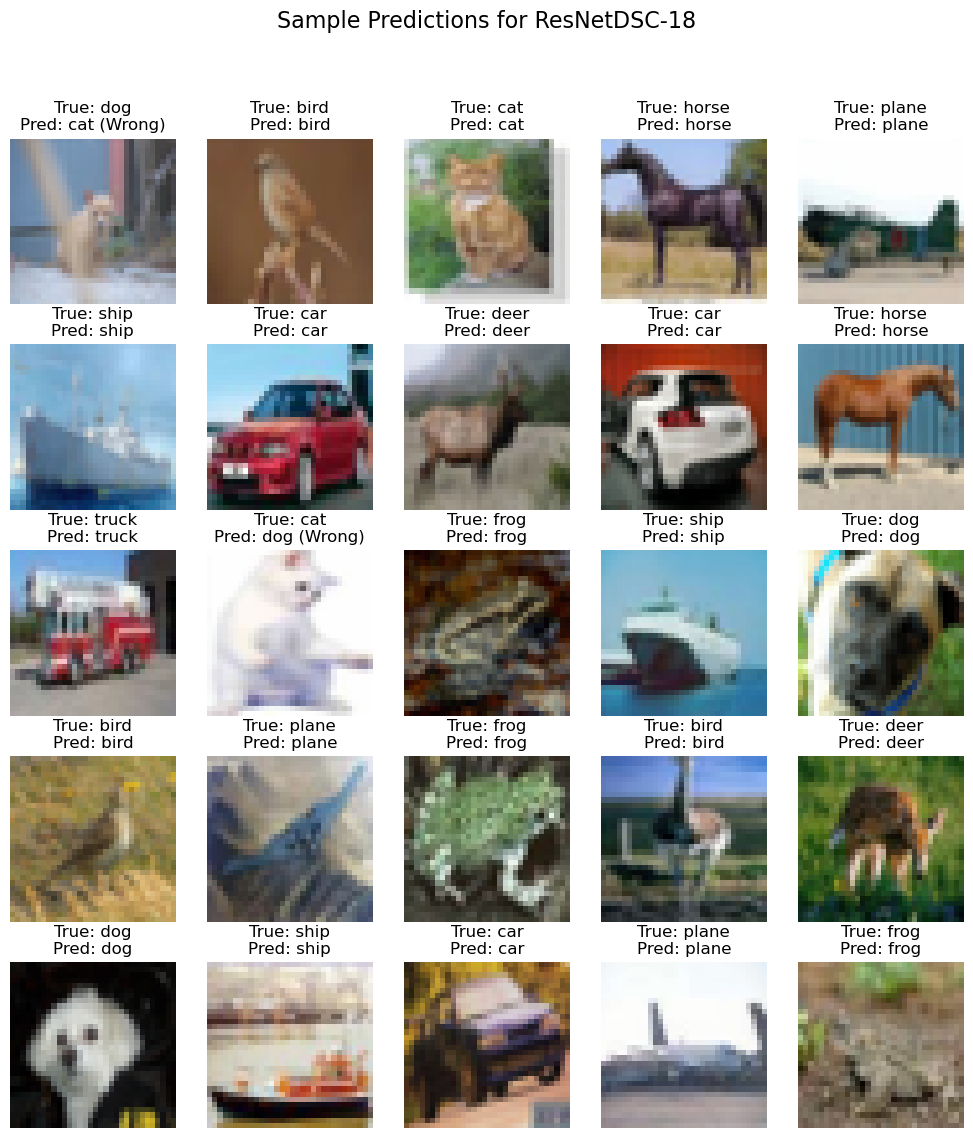

In [52]:
# 1. 训练过程可视化
print("绘制 ResNetDSC-18 训练曲线...")
plot_training_curves(range(1, EPOCHS_RESNET + 1), train_losses_resnet, train_accuracies_resnet, model_name="ResNetDSC-18")

# 2. 混淆矩阵
print("绘制 ResNetDSC-18 混淆矩阵...")
plot_confusion_matrix_heatmap(true_labels_resnet, pred_labels_resnet, classes, model_name="ResNetDSC-18")

# 3. 样本图片、真实标签与预测标签展示
print("可视化 ResNetDSC-18 样本预测...")
visualize_sample_predictions(testset, model_resnet_dsc, device, classes, num_images=25, model_name="ResNetDSC-18")

### R5. 保存 ResNetDSC-18 模型

In [53]:
MODEL_PATH_RESNET = 'cifar10_resnetdsc18.pth'
torch.save(model_resnet_dsc.state_dict(), MODEL_PATH_RESNET)
print(f"ResNetDSC-18 模型已保存到: {MODEL_PATH_RESNET}")

ResNetDSC-18 模型已保存到: cifar10_resnetdsc18.pth
